In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

# Sigmoid Curve

Using a probability threshold to classify an instance.  Our model is not predicting 1 or 0, our model is predicting the probability of a 1 

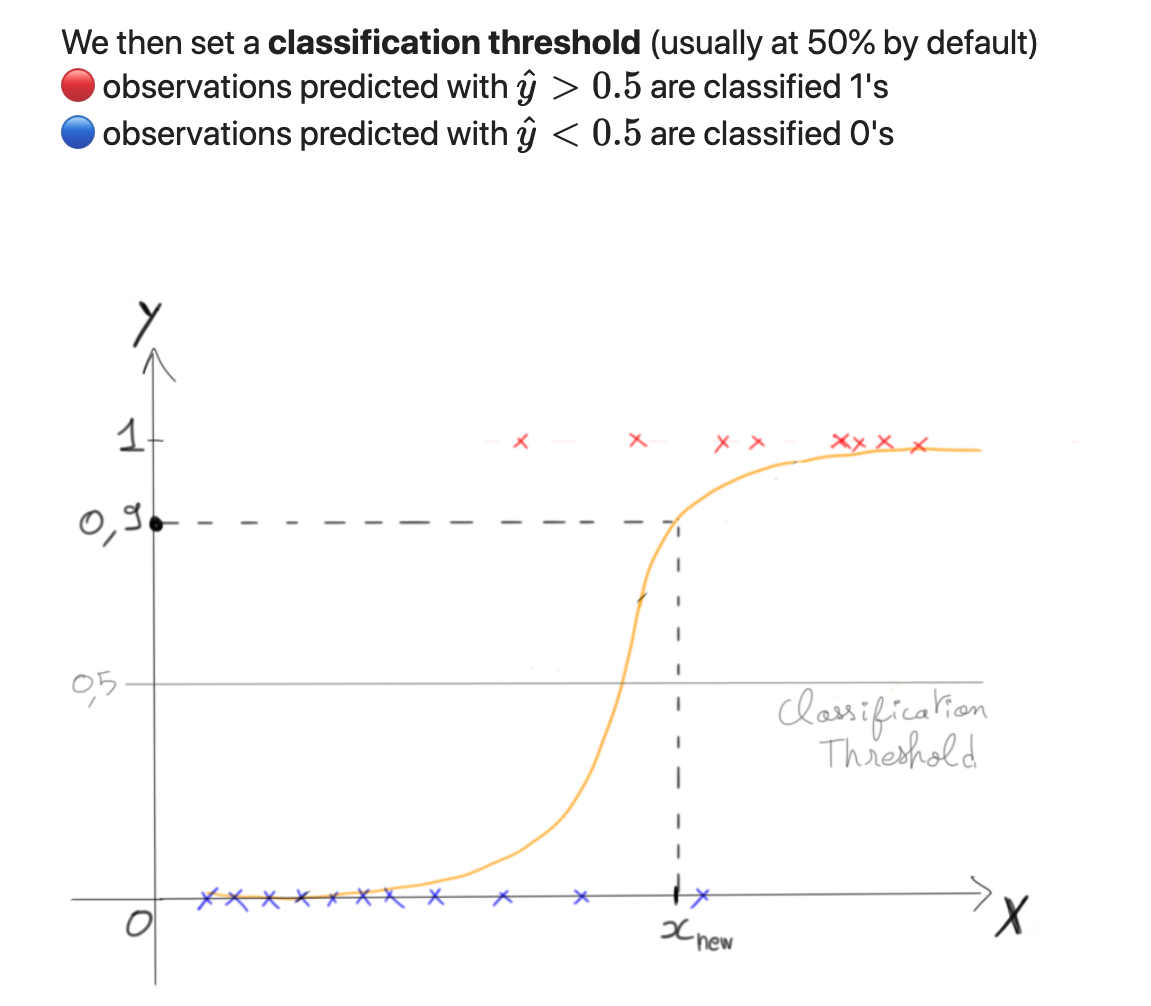

In [2]:
Image(filename='sigmoid.png', width=750)

# Logit Conversion

Converting probabilities into log odds to view a linear relationship and **add explainability**.  Moving from a [0-1] probability space to an infinite log-odds space

In [5]:
# Setup a range from 1% probability to 100% probability
p = np.arange(0.01, 1, 0.005)
print('Probabilities: ', p[0:2],  p[-2:])

# Convert probabilities to odds 0.01 / (1-0.01) <=> (0.99)
odds = p / (1-p)
print('Odds: ', odds[0:2], odds[-2:])

# Get the natural log of those odds
log_odds = np.log(odds)
print('Log Odds: ', log_odds[0:2], log_odds[-2:])

Probabilities:  [0.01  0.015] [0.99  0.995]
Odds:  [0.01010101 0.01522843] [ 99. 199.]
Log Odds:  [-4.59511985 -4.18459144] [4.59511985 5.29330482]


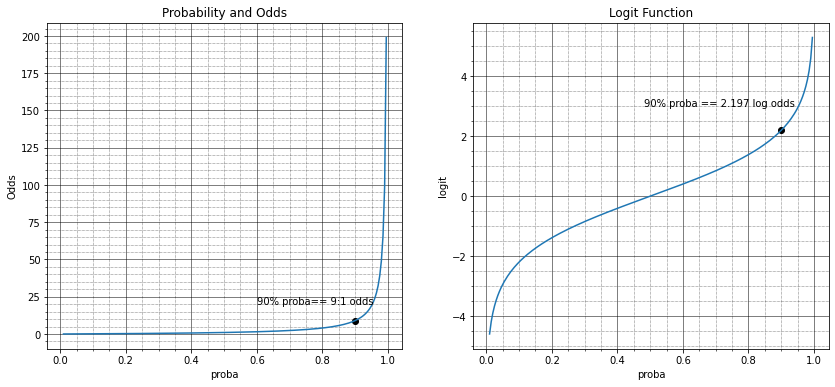

To convert back:
e**logodds == odds
2.718..**2.197.. == 9
odds / (1+odds) == prob
9 / 10 == 0.9


In [6]:
# log-odds = LOGIT
plt.figure(figsize=(14,6))

# Plot our probabilty vs. odds
plt.subplot(1,2,1)
plt.plot(p, odds); plt.ylabel("Odds"); plt.xlabel("proba")
plt.title('Probability and Odds')
# Add grid
plt.grid(); plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
# Add marker
plt.text(0.6, 20, '90% proba== 9:1 odds')
plt.scatter(0.9, (0.9/(1-0.9)), c='black')

# Plot our probability vs log odds
plt.subplot(1,2,2)
plt.plot(p, np.log(odds)); plt.xlabel('proba'); plt.ylabel('logit')
plt.title('Logit Function')
# Add grid
plt.grid(); plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
#Add marker
plt.text(0.48, 3, '90% proba == 2.197 log odds')
plt.scatter(0.9, np.log(0.9/(1-0.9)), c='black');
plt.show()
print('To convert back:')
print('e**logodds == odds')
print('2.718..**2.197.. == 9')
print('odds / (1+odds) == prob')
print('9 / 10 == 0.9')

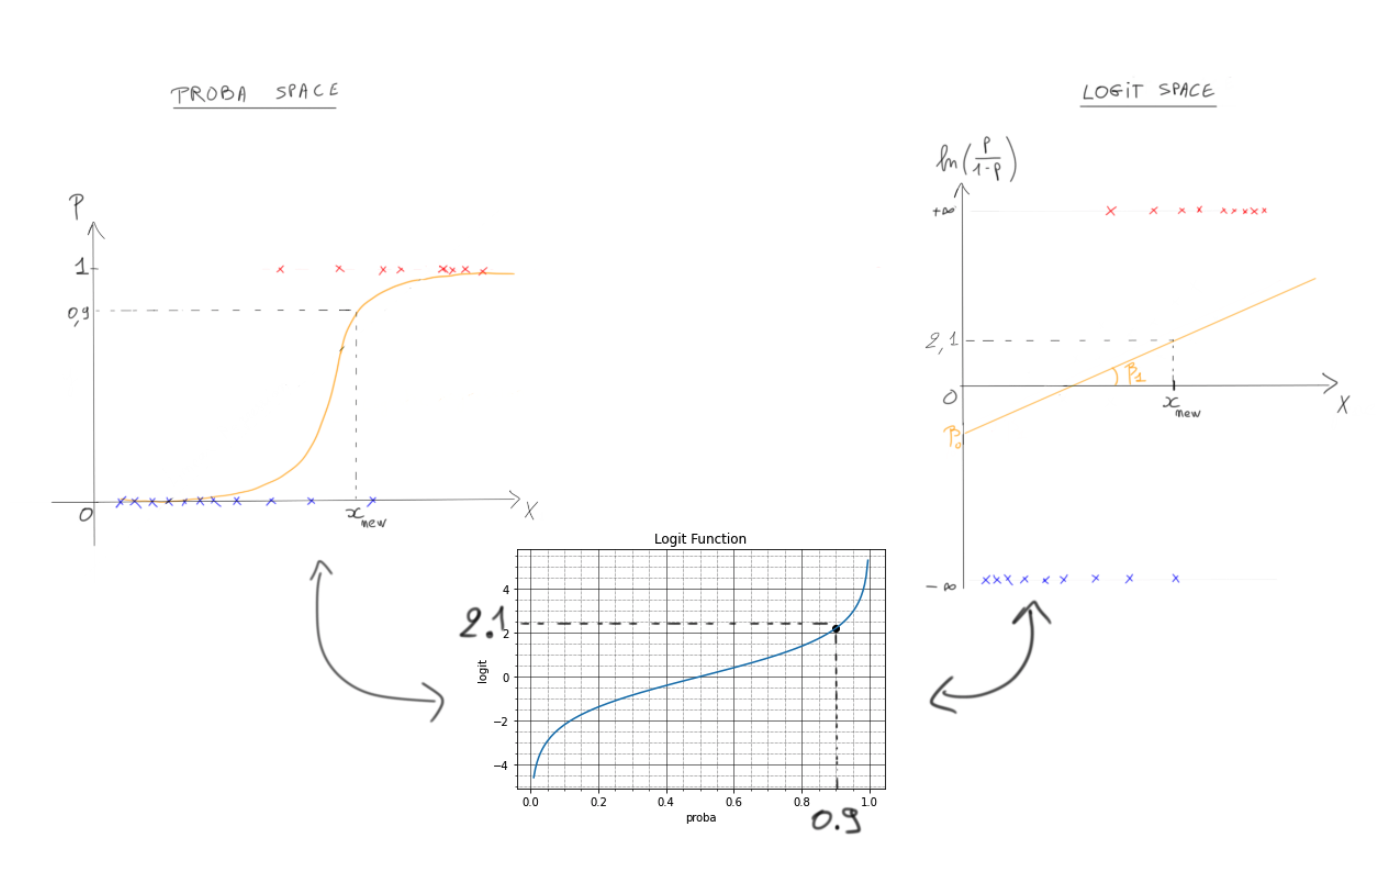

In [7]:
Image(filename='logit.png', width=900)

# Interpreting the transformation


In [8]:
titanic = sns.load_dataset("titanic")
titanic.head(3)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True


### No Features - just intercept

What is the overall survival rate of the dataset?

In [9]:
# probability of survival == total survived (number of "1"'s in "survived"') / total passengers (number of rows)
# Can simply just use the mean
titanic.survived.mean()

0.3838383838383838

How can we can get that explainability through our statsmodel?

In [10]:
import statsmodels.formula.api as smf

# We don't pass any columns to use to predict so it will predict the mean
# The intercept would be the overall survival logodd
# Proof of concept
model1 = smf.logit(formula='survived ~ 1', data=titanic).fit();
model1.params

Optimization terminated successfully.
         Current function value: 0.665912
         Iterations 4


Intercept   -0.473288
dtype: float64

**log_odd** = -0.473288

**odd** (e^odd = log_odd): ~2.178^odd = -0.473288 <==> odd = 0.62

**proba** (odd/1+odd): 0.62 / (1+0.62) <==> proba = 0.38

### With Features

Now that we now we can explain the results, lets add features

In [11]:
# Slopes refer to increase in LOG ODDS not probabilities
model2 = smf.logit(formula='survived ~ fare', data=titanic).fit()
model2.params

Optimization terminated successfully.
         Current function value: 0.627143
         Iterations 6


Intercept   -0.941330
fare         0.015197
dtype: float64

#### Explaining our slopes

**$1 in fare increase results in 0.015197 increase in log odds**

**According to the model, someone who paid $0 in fare has a:**

*log odds* of survival (intercept) of -0.941330

*odds* of survival (exp(log odds)) of 0.390108

*probability* of survival (odds / (1+odds)) of 0.2806 

**Someone who paid $1 in fare has a:**

*log odds* of survival (intercept + (slope*fare)) of -0.926133

*odds* of survival (exp(log odds)) of 0.39608 

*probability* of survival (odds / (1+odds)) of 0.2837

In [12]:
import math
print('Odds percent increase with $1 increase: ', round(math.exp(model2.params[1]),3))
print('Manually: 0.390108 vs 0.39608:', round(0.39608/0.390108,3))
print('probability increase: ', round(0.2837/0.2806,3))

Odds percent increase with $1 increase:  1.015
Manually: 0.390108 vs 0.39608: 1.015
probability increase:  1.011


# Multi-colinearity

In [13]:
A = np.array([[1., 0., 1.],[0., 1., 1.],[0., 0., 0.]])
B = np.array([[1., 0., 0.],[0., 1., 0.],[0., 0., 1.]])
display(A)
B

array([[1., 0., 1.],
       [0., 1., 1.],
       [0., 0., 0.]])

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [14]:
# Strict Multicolinearity
# Column 3 is a sum of column 1 and column 2 in matrix A
print('sum A1 and A2: ', (A[:, 0] + A[:,1]))
print('A3 actual:    ', A[:, 2])

sum A1 and A2:  [1. 1. 0.]
A3 actual:     [1. 1. 0.]


In [15]:
# Not the same for B
print('sum B1 and B2: ', (B[:, 0] + B[:,1]))
print('B3 actual:     ', B[:, 2])

sum B1 and B2:  [1. 1. 0.]
B3 actual:      [0. 0. 1.]


In [16]:
# Rank will detect strict multicollinearity
print('rank(A):', np.linalg.matrix_rank(A),
      '\nrank(B):', np.linalg.matrix_rank(B))

rank(A): 2 
rank(B): 3


###  VIF to detect non-strict multicollinearity

In [17]:
# Load df
mpg = sns.load_dataset('mpg').dropna().drop(columns=['origin', 'name', 'displacement'])

# add a column with perfect collinearatiy
mpg['lin_comb'] = 10 * mpg['cylinders'] - 0.3 * mpg['horsepower']
display(mpg.head(3))
print('Columns: ', mpg.shape[1])
print('Rank: ', np.linalg.matrix_rank(mpg))

,mpg,cylinders,horsepower,weight,acceleration,model_year,lin_comb
0,18.0,8,130.0,3504,12.0,70,41.0
1,15.0,8,165.0,3693,11.5,70,30.5
2,18.0,8,150.0,3436,11.0,70,35.0


Columns:  7
Rank:  6


We add some slight "noise" to trick the 'rank' method


In [18]:
mpg['lin_comb'] = mpg['lin_comb'] +  0.05 * np.random.rand(mpg.shape[0])
display(mpg.head(3))
print('Columns: ', mpg.shape[1])
print('Rank: ', np.linalg.matrix_rank(mpg))

,mpg,cylinders,horsepower,weight,acceleration,model_year,lin_comb
0,18.0,8,130.0,3504,12.0,70,41.013690
1,15.0,8,165.0,3693,11.5,70,30.535550
2,18.0,8,150.0,3436,11.0,70,35.035483


Columns:  7
Rank:  7


Correlation matix is not sufficient to detect soft or event strict multicolinearity.  lin_comb looks normal in our heatmap

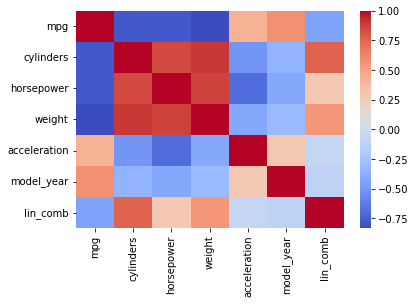

In [19]:
sns.heatmap(mpg.corr(), cmap='coolwarm');

**Always remember to scale your data**

In [20]:
mpg_scaled = mpg.copy()

for feature in mpg_scaled.columns:
    mu = mpg[feature].mean()
    sigma = mpg[feature].std()
    mpg_scaled[feature] = mpg_scaled[feature].apply(lambda x: (x-mu)/sigma)
    
mpg_scaled.head()

,mpg,cylinders,horsepower,weight,acceleration,model_year,lin_comb
0,-0.697747,1.482053,0.663285,0.619748,-1.283618,-1.623241,1.833889
1,-1.082115,1.482053,1.572585,0.842258,-1.464852,-1.623241,0.742751
2,-0.697747,1.482053,1.182885,0.539692,-1.646086,-1.623241,1.211350
3,-0.953992,1.482053,1.182885,0.536160,-1.283618,-1.623241,1.209873
4,-0.825870,1.482053,0.923085,0.554997,-1.827320,-1.623241,1.520626


In [21]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
# instantiate a blank dataframe
df = pd.DataFrame()

# compute VIF factor for feature column 0 ==> end
df["vif_index"] = [round(vif(mpg_scaled.values, i),2) for i in range(mpg_scaled.shape[1])]

# add corresponding feature column names, and sort
df["features"] = mpg_scaled.columns
df.sort_values('vif_index', ascending=False)

,vif_index,features
1,1335471.10,cylinders
2,612787.35,horsepower
6,423395.36,lin_comb
3,11.37,weight
0,5.23,mpg
4,2.66,acceleration
5,1.89,model_year


Remove our troubled features and re-run.  Number of cylinders and horsepower are already being represented in the data by the lin_comb feature, why would we still need them?

In [22]:
mpg2 = mpg_scaled.drop(columns=['cylinders','horsepower'])

mpg2.head(2)

,mpg,weight,acceleration,model_year,lin_comb
0,-0.697747,0.619748,-1.283618,-1.623241,1.833889
1,-1.082115,0.842258,-1.464852,-1.623241,0.742751


In [25]:
# instantiate a blank dataframe
df = pd.DataFrame()

# compute VIF factor for feature index 0
df["vif_index"] = [round(vif(mpg2.values, i),2) for i in range(mpg2.shape[1])]

# add corresponding feature name
df["features"] = mpg2.columns
df.sort_values('vif_index', ascending=False)

,vif_index,features
0,5.23,mpg
1,4.50,weight
3,1.80,model_year
4,1.52,lin_comb
2,1.31,acceleration
